<a href="https://colab.research.google.com/github/mlvlab/data303/blob/main/Image_Generation_by_Gaussian.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Density Estimation
======

* Gaussian

In [1]:
# install pytorch (http://pytorch.org/) if run from Google Colaboratory
import sys
import matplotlib.pyplot as plt
%matplotlib inline
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import numpy as np

use_gpu = True

MNIST Data Loading
-------------------

MNIST images show digits from 0-9 in 28x28 grayscale images. We do not center them at 0, because we will be using a binary cross-entropy loss that treats pixel values as probabilities in [0,1]. We create both a training set and a test set.

In [2]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

img_transform = transforms.Compose([
    # list of transforms to compose :
    transforms.ToTensor()
])
# `train_dataset` is a "MNIST" type
train_dataset = MNIST(root='./data', download=True, train=True, transform=img_transform)
# batch_size = 60000
batch_size = len(train_dataset)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

# for calls __iter__ and __next__ methods ..?
for X, y in train_dataloader:
    # X : [60000, 1, 28, 28] : image
    # y : [60000] : label
    break;


In [3]:

# torch.cuda.is_available() : True
device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
# device = "cuda:0"

In [4]:
"""functions for visualisation"""

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    
def to_img(x):
    """project pixel values on the unit interval [0,1]
    x : image tensor
    """
    x = x.clamp(0, 1)
    return x

def imshow_tensor(img, cmap='gray'):
    img = to_img(img)
    if img.get_device() >=0:    # .get_device() : -1 if on CPU, 0 if 'cuda:0'
        img = img.cpu()
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap=cmap)
    
def imshow_cov_tensor(S, cmap='gray'):
    """
    visualise the covariance matrix as an image
    S : covariance matrix
    """

    imshow_tensor(S[None, ...], cmap=cmap)

Compute Mean and Covariance Matrix without iterations 
=========================

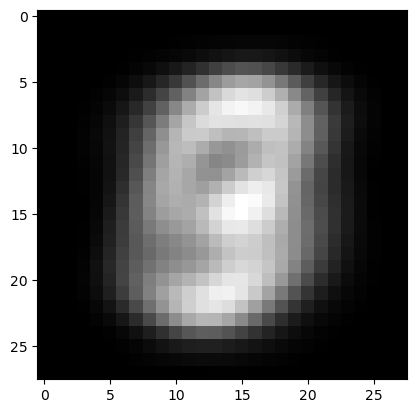

In [5]:
# Compute Mean of training data
mu = torch.mean(X,0)
imshow_tensor(mu)

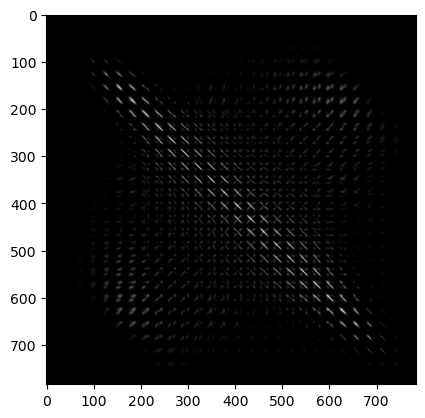

In [9]:
# Compute covariance matrix of training data
S = torch.cov(X.reshape(batch_size,-1).transpose(1,0))
# S.shape : [784, 784]
imshow_cov_tensor(S)

Generate samples from learned Gaussian
==========================
* $\mu$ is the sample mean 
* $S$ is the sample covariance matrix 
* We use $\tilde{S} + \alpha I$ to have a positive definite covariance matrix, where $\alpha>0$ is small

In [10]:
# Add small identify to avoid rank-deficient covariance matrix (0 variance... at some pixels)
alpha = 0.0001
Saug = S+alpha*torch.eye(S.shape[0]) # Augment the Covariance Matrix : S + alpha*I
mu_vec= mu.view(-1)

# Creates a multivariate normal (also called Gaussian) distribution parameterized by a mean vector and a covariance matrix.
mvn = torch.distributions.multivariate_normal.MultivariateNormal(mu_vec, Saug)


In [11]:
x_gen = mvn.sample().reshape(1,28,-1)

In [12]:
n_samples = 50
width = 28
height = 28

X_gen = torch.zeros(n_samples, width, height)
for i in range(50):
    X_gen[i] = mvn.sample().reshape(28,-1)

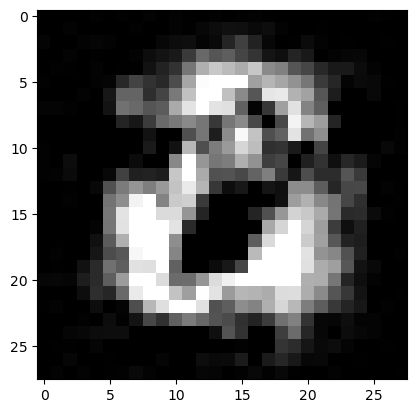

In [13]:
idx = 0
# X_gen.shape : [50, 28, 28]
# X_gen[None, idx, ...].shape : [1, 28, 28]
# None : add a dimension to X_gen tensor as it is required by imshow_tensor function
# idx : index of the image to visualize
# ... : rest of the dimensions of X_gen is kept
imshow_tensor(X_gen[None, idx, ...]) # visualize the first image

In [14]:
X_gen[None, idx, ...].shape

torch.Size([1, 28, 28])

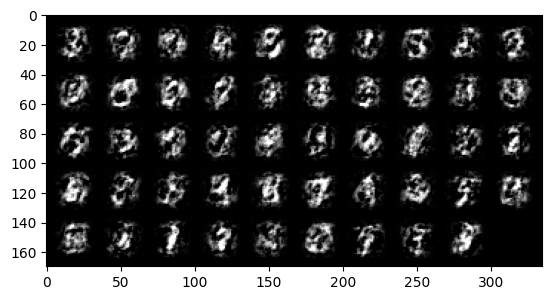

In [12]:
# Visualize all the generated images
images = X_gen.cpu()[:,None,...]
images = to_img(images)
np_imagegrid = torchvision.utils.make_grid(images[1:50], 10, 5).numpy()
plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
plt.show()